In [1]:
import os
import json
import pprint
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Owein\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Augment the images

In [23]:
import albumentations as A
import cv2

In [168]:
monet_jpg_filename = tf.io.gfile.glob("data/AllMonets/*.jpg")
images_jpg_filename = tf.io.gfile.glob("data/AllImages/*.jpg")

In [169]:
# Declare an augmentation pipeline
HorizontalFlip = A.Compose([
    # A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5)
    # A.RandomBrightnessContrast(p=0.2),
])
RandomCrop = A.Compose([
    A.RandomSizedCrop(min_max_height=(150, 150), height=256, width=256, p=1.0)
])

In [170]:
def random_crops(image,n=1):
    random_cropped_images = []
    for i in range(n):
        random_cropped_images.append(RandomCrop(image=image)["image"])
    return random_cropped_images

In [171]:
def rotation(image, n=1):
    random_flipped_images = []
    # delta = np.linspace(0,1,n)
    for i in range(n):
        random_flipped_images.append(A.Rotate(70, p=1)(image=image)["image"])
    return random_flipped_images

In [172]:
# Read an image with OpenCV and convert it to the RGB colorspace
transformed_images = []
for i in range(len(monet_jpg_filename)):
    image = cv2.imread(monet_jpg_filename[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed_images.append(image)
    transformed_images = transformed_images + rotation(image) # add the flipped images to the list
    transformed_images = transformed_images + random_crops(image) # add random crops to the list
    
# # Augment an image
# transformed = HorizontalFlip(image=image)
# transformed_image = transformed["image"]
len(transformed_images)

3579

### Save new images generated

In [ ]:
from PIL import Image


In [159]:
i = 0
for image in transformed_images:
    im = Image.fromarray(image)
    im.save("./data/AugmentedDataset/im_{}.jpg".format(i))
    i=i+1
    

(-0.5, 255.5, 255.5, -0.5)

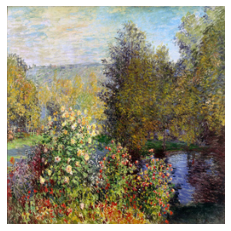

In [175]:
# for image in transformed_images:
#     plt.figure()
#     plt.imshow(image)
#     plt.axis("off")

# plt.subplot(121)
# plt.title('Photo')
# plt.imshow(image)
plt.figure()
plt.imshow(transformed_images[0])
plt.axis("off")
# plt.subplot(122)
# plt.title('Transformed')
# plt.imshow(transformed_image)

## Create the tf_rec of the files

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )
def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))

def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example
def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [182]:
photo_jpg_filename = tf.io.gfile.glob("data/trainB/*.jpg")  # list of images to transform into tfrecords
monet_jpg_filename = tf.io.gfile.glob("data/AllMonets/*.jpg")

In [183]:
#Create the annotations ... Basicly the filename
photo_annotations = [ {"image":x.split("/")[-1], "path":x} for x in photo_jpg_filename]
monet_annotations = [ {"monet":x.split("/")[-1], "path":x} for x in monet_jpg_filename]

In [6]:
input_path = "./50_100_256px/"
dir_path = "./50_100_256px_tfrec/"
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
path_file_jpg = tf.io.gfile.glob(str(input_path)+"*.png")
image_annotations = [ {"image":x.split("/")[-1], "path":x} for x in path_file_jpg]
num_samples = 60
num_tfrecords_images = len(image_annotations) // num_samples
if len(image_annotations) % num_samples:
    num_tfrecords_images += 1  # add one record if there are any remaining samples
# Create tfrec for the monets
for tfrec_num in range(num_tfrecords_images):
    samples = image_annotations[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]
    with tf.io.TFRecordWriter(
       str(dir_path) + "file_%.2i-%i.tfrec" % (tfrec_num, len(samples))
    ) as writer:
        for sample in samples:
            image_path = sample['path']
            image = tf.io.decode_jpeg(tf.io.read_file(image_path))
            example = create_example(image, image_path, sample)
            writer.write(example.SerializeToString())

In [184]:
len(monet_annotations)

1193

In [ ]:
# Create tfrec for the photos
tfrecords_dir = "./tfrecords"
num_samples = 60
num_tfrecords_photos = len(photo_annotations) // num_samples
if len(photo_annotations) % num_samples:
    num_tfrecords_photos += 1  # add one record if there are any remaining samples

if not os.path.exists("tfr"):
    os.makedirs(os.path.join("tfr","images"))
    os.makedirs(os.path.join("tfr","monets"))

In [186]:
# Create tfrec for the monet
num_samples = 60
num_tfrecords_monet = len(monet_annotations) // num_samples
if len(monet_annotations) % num_samples:
    num_tfrecords_monet += 1  # add one record if there are any remaining samples

In [ ]:
# Create tfrec for the photos
for tfrec_num in range(num_tfrecords_photos):
    samples = photo_annotations[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]
    with tf.io.TFRecordWriter(
        "tfr/images/" + "file_%.2i-%i.tfrec" % (tfrec_num, len(samples))
    ) as writer:
        for sample in samples:
            image_path = sample['path']
            image = tf.io.decode_jpeg(tf.io.read_file(image_path))
            example = create_example(image, image_path, sample)
            writer.write(example.SerializeToString())

In [188]:
# Create tfrec for the monet
for tfrec_num in range(num_tfrecords_monet):
    samples = monet_annotations[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]
    with tf.io.TFRecordWriter(
       "tfrv2/monets/" + "file_%.2i-%i.tfrec" % (tfrec_num, len(samples))
    ) as writer:
        for sample in samples:
            image_path = sample['path']
            image = tf.io.decode_jpeg(tf.io.read_file(image_path))
            example = create_example(image, image_path, sample)
            writer.write(example.SerializeToString())

In [164]:
MONET_FILENAMES = tf.io.gfile.glob("./tfr/monets/*.tfrec")
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob("./tfr/images/*.tfrec")
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 100
Photo TFRecord Files: 105


In [9]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

path: b'data\\trainA\\00001.jpg'
Image shape: (256, 256, 3)


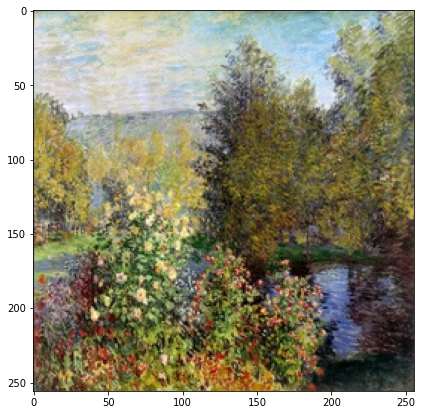

In [10]:
raw_dataset = tf.data.TFRecordDataset("./tfr/monets/file_00-60.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

In [11]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)



In [ ]:
monet_ds

<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

In [ ]:
np_list = list(monet_ds.as_numpy_iterator())


In [ ]:
example_monet = np_list[10]

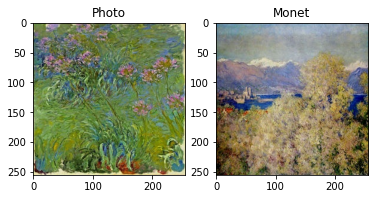

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  # layers.RandomCrop(150, 150),
  layers.RandomRotation(0.05),
])

In [12]:
from random import random


IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])
vertical_flip = tf.keras.Sequential([
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
])

random_crop = tf.keras.Sequential([
  layers.RandomCrop(150, 150)
])


In [15]:
batch_size = 1
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  # ds = ds.map(lambda x: (resize_and_rescale(x)), 
  #             num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # # Batch all datasets.
  # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x: (data_augmentation(x, training=True)), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
aug_ds  = prepare(monet_ds, shuffle=True, augment=True)

In [19]:
#Get the size of a dataset
def get_dataset_size(ds):
    size = 0
    for i in ds:
        size += 1
    return size


<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [21]:
print(get_dataset_size(aug_ds))
print(get_dataset_size(monet_ds))

1072
1072


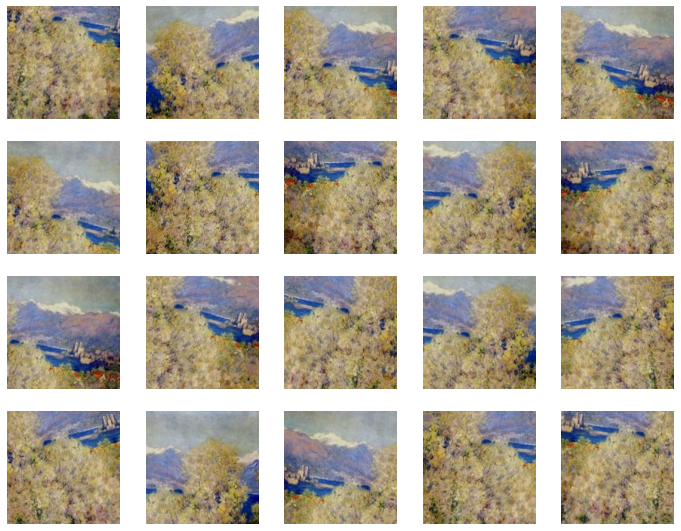

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# plt.figure(figsize=(12, 12))
# augmented_images =
for i in range(20):
  augmented_image = data_augmentation(example_monet)
  # ax = plt.subplot(5, 5, i + 1)
  # plt.imshow(augmented_image[0] / 2 + 0.5)
  # plt.axis("off")


In [ ]:
aug_ds = monet_ds.map(
  lambda x: (data_augmentation(x, training=True)))

In [ ]:
monet_ds

<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [ ]:
aug_ds

<MapDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>